# Trabalho Prático 1: Compressão de Imagens

**Grupo**:

- Isis Ferreira Carvalho (2020006663)
- Lucas Mesquita Andrade (2020054668)
- Victor Augusto de Lima Cruz (2020054854)

## Ideia

comparar JPEG com várias tarsnformadas com DEFLATE e sua combinação.

elaborar

## Implementação

In [107]:
# Importações
%matplotlib inline
import cv2
import io
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
import matplotlib.image as mpimg

from collections import Counter
import heapq

import struct
import json
import pickle

In [108]:
"""
    Função de leitura de dados (e conversão pra escala de cinza) {TO-DO: função pra ler dados, plotar dado inicial}
"""

img = cv2.imread('lena512.pgm',0)


### Huffman

In [116]:
""" 
    Lógica da Codificação de Huffman, com métodos de codificação e decodificação {TO-DO: COMENTAR ESSE CÓDIGO DIREITO}
"""

def calculate_frequencies(arr):
    flattened = arr.flatten()
    return Counter(flattened)

class HuffmanNode:
    def __init__(self, value=None, freq=0):
        self.value = value
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(frequencies):
    heap = [HuffmanNode(value, freq) for value, freq in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(freq=node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    return heap[0]

def generate_huffman_codes(node, prefix='', codebook=None):
    if codebook is None:
        codebook = {}
    if node.value is not None:
        codebook[node.value] = prefix
    else:
        generate_huffman_codes(node.left, prefix + '0', codebook)
        generate_huffman_codes(node.right, prefix + '1', codebook)
    return codebook

def encode_array(arr, codebook):
    flattened = arr.flatten()
    encoded_bits = ''.join(codebook[value] for value in flattened)
    return encoded_bits

def save_encoded_data(encoded_bits, codebook, original_shape, file_path):
    with open(file_path, 'wb') as f:
        # Save the original shape
        f.write(struct.pack('>II', *original_shape))
        codebook_converted = {int(k): v for k, v in codebook.items()}
        
        # Save the codebook
        codebook_str = json.dumps(codebook_converted)
        f.write(struct.pack('>I', len(codebook_str)))
        f.write(codebook_str.encode('utf-8'))
        
        # Save the encoded bitstream length
        bitstream_len = len(encoded_bits)
        f.write(struct.pack('>I', bitstream_len))
        
        # Save the encoded bitstream
        byte_array = bytearray()
        for i in range(0, bitstream_len, 8):
            byte = encoded_bits[i:i+8]
            byte_array.append(int(byte.ljust(8, '0'), 2))
        f.write(byte_array)

def load_encoded_data(file_path):
    with open(file_path, 'rb') as f:
        # Read the original shape
        original_shape = struct.unpack('>II', f.read(8))
        
        # Read the codebook
        codebook_len = struct.unpack('>I', f.read(4))[0]
        codebook_str = f.read(codebook_len).decode('utf-8')
        codebook = json.loads(codebook_str)
        
        # Read the encoded bitstream length
        bitstream_len = struct.unpack('>I', f.read(4))[0]
        
        # Read the encoded bitstream
        bitstream_bytes = f.read()
        encoded_bits = ''.join(format(byte, '08b') for byte in bitstream_bytes)[:bitstream_len]
    
    return encoded_bits, codebook, original_shape

def decode_huffman(encoded_bits, codebook):
    reverse_codebook = {v: k for k, v in codebook.items()}
    decoded_values = []
    
    current_bits = ''
    for bit in encoded_bits:
        current_bits += bit
        if current_bits in reverse_codebook:
            decoded_values.append(reverse_codebook[current_bits])
            current_bits = ''
    
    return decoded_values

def bits_to_array(decoded_values, original_shape):
    return np.array(decoded_values).reshape(original_shape)

### JPEG

In [109]:
"""
    Função que faz o padding da imagem caso sua altura ou largura não sejam múltiplos de 8
"""
def pad_image(img, block_size):

    width, height = img.shape[0], img.shape[1]

    if width % 8 != 0 or height % 8 != 0:
        #padding é necessário
        height = np.float32(height) 
        width = np.float32(width) 

        new_width = np.int32(math.ceil(width/block_size) * block_size)
        new_height = np.int32(math.ceil(height/block_size) * block_size)

        padded_img = np.zeros((new_width, new_height))
        padded_img[0:int(height),0:int(width)] = img[0:int(height),0:int(width)]

        width, height = new_width, new_height
        cv2.imwrite('padded_img.bmp', np.uint8(padded_img)) #inserir nome na representação intermediária do file
    else:
        padded_img = img

    return padded_img, width, height

In [110]:
"""
    Funções de aplicação de transformadas e suas inversas
"""
def apply_dct(img):
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def apply_idct(coefficients):
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

In [111]:
"""
    Função de caminhamento em zigzag na matriz pós-transofrmada e quantização, para captar maiores coeficientes primeiro
    {TO-DO: melhorar comentários como se fossem nossos}
"""

def zigzag(input):
    h, v = 0, 0
    vmin, hmin = 0, 0
    vmax = input.shape[0]
    hmax = input.shape[1]
    i = 0

    output = np.zeros((vmax * hmax))

    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:                 # going up
            if (v == vmin):
                output[i] = input[v, h]        # if we got to the first line
                if (h == hmax):
                    v += 1
                else:
                    h += 1
                i += 1
            elif ((h == hmax - 1) and (v < vmax)):   # if we got to the last column
                output[i] = input[v, h]
                v += 1
                i += 1
            elif ((v > vmin) and (h < hmax - 1)):    # all other cases
                output[i] = input[v, h]
                v -= 1
                h += 1
                i += 1
        else:                                    # going down
            if ((v == vmax - 1) and (h <= hmax - 1)):       # if we got to the last line
                output[i] = input[v, h]
                h += 1
                i += 1
            elif (h == hmin):                  # if we got to the first column
                output[i] = input[v, h]
                if (v == vmax - 1):
                    h += 1
                else:
                    v += 1
                i = i + 1
            elif ((v < vmax - 1) and (h > hmin)):     # all other cases
                output[i] = input[v, h]
                v += 1
                h -= 1
                i += 1

        if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
            output[i] = input[v, h]
            break

    return output.astype(int)

In [112]:
"""
    Declaração da matriz de quantização a ser usada na codificação
"""
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

In [113]:
""" 
    {TO-DO: DAR UNS PRINT EM RESULTADOS INTERMEDIÁRIOS, COMENTAR, PENSAR MELHRO NO FLUXO}
"""
def encode_jpeg(img, transformada, quantiz_matrix):
    img = img.astype(float)
    img = img-128
    block_size = 8
    padded_img, width, height = pad_image(img, block_size)
    # num_blocks_w, num_blocks_h = width/block_size, height/block_size

    new_img = np.zeros((width, height)).astype(int) # Para guardar representação pós transformada, quantização e zigzag

    for x in range(0, width, block_size):
        for y in range(0, height, block_size):
            block = padded_img[x:x+block_size, y:y+block_size]
            dct = transformada(block)
            dct_quantized = np.round(np.divide(dct, quantiz_matrix)).astype(int)
            dct_zigzag = zigzag(dct_quantized)
            reshaped = np.reshape(dct_zigzag, (block_size, block_size))
            new_img[x:x+block_size, y:y+block_size] = reshaped

    # HUFFMAN
    arr = np.array(new_img)
    frequencies = calculate_frequencies(arr)
    huffman_tree = build_huffman_tree(frequencies)
    codebook = generate_huffman_codes(huffman_tree)
    encoded_bits = encode_array(arr, codebook)
    save_encoded_data(encoded_bits, codebook, arr.shape, 'encoded_image.bin')

    return new_img

In [114]:
new_img = encode_jpeg(img, apply_dct, QM)

In [115]:
new_img

array([[16,  0,  1, ..., -8,  1, -3],
       [ 0,  0,  0, ...,  0, -1,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

#### DECODIFICAÇÃO DAQUI PRA BAIXO, TERMINAR!!!!

In [139]:
# Example usage
encoded_bits_read, codebook_read, original_shape_read = load_encoded_data('encoded_image.bin')
codebook_treated = {int(k):v for k,v in codebook_read.items()}
decoded_values = decode_huffman(encoded_bits_read, codebook_treated)
reconstructed_array = bits_to_array(decoded_values, original_shape_read)
reconstructed_array = reconstructed_array.astype(int) + 128
# print(reconstructed_array)

In [141]:
img

array([[162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       ...,
       [ 43,  43,  50, ..., 104, 100,  98],
       [ 44,  44,  55, ..., 104, 105, 108],
       [ 44,  44,  55, ..., 104, 105, 108]], dtype=uint8)

In [140]:
reconstructed_array

array([[144, 128, 129, ..., 120, 129, 125],
       [128, 128, 128, ..., 128, 127, 128],
       [128, 128, 128, ..., 128, 128, 128],
       ...,
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128]])

In [138]:
reconstructed_array

array([[16,  0,  1, ..., -8,  1, -3],
       [ 0,  0,  0, ...,  0, -1,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

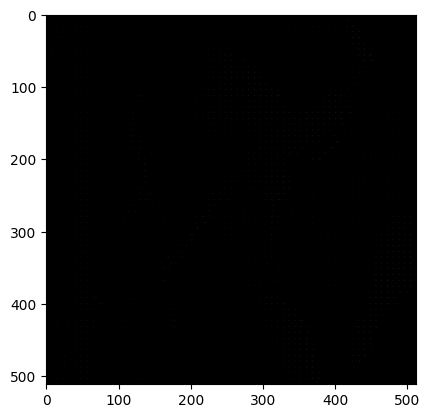

In [137]:
plt.imshow(reconstructed_array, cmap = 'gray', clim=(0, 255))

In [104]:
reconstructed_array.astype(int) + 128
reconstructed_array = reconstructed_array.astype(int) + 128

In [105]:
reconstructed_array

array([[144, 128, 129, ..., 120, 129, 125],
       [128, 128, 128, ..., 128, 127, 128],
       [128, 128, 128, ..., 128, 128, 128],
       ...,
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128]])

### Comprimento de corrida

In [89]:
new_img.astype('uint8').tofile('test_file.txt')

In [90]:
# contém dúvida

In [91]:
def get_run_length_encoding(image):
    i = 0
    skip = 0
    stream = []    
    bitstream = ""
    image = image.astype(int)
    while i < image.shape[0]:
        if image[i] != 0:            
            stream.append((image[i],skip))
            bitstream = bitstream + str(image[i])+ " " +str(skip)+ " "
            skip = 0
        else:
            skip = skip + 1
        i = i + 1

    return bitstream

In [92]:
arranged = new_img.flatten()

# Now RLE encoded data is written to a text file (You can check no of bytes in text file is very less than no of bytes in the image
# THIS IS COMPRESSION WE WANTED, NOTE THAT ITS JUST COMPRESSION DUE TO RLE, YOU CAN COMPRESS IT FURTHER USING HUFFMAN CODES OR MAY BE 
# REDUCING MORE FREQUENCY COEFFICIENTS TO ZERO)

bitstream = get_run_length_encoding(arranged)

In [93]:
bitstream

'16 0 1 1 16 5 2 0 1 0 14 5 1 0 1 0 -1 3 13 1 1 4 15 2 -2 0 1 0 1 2 -1 1 21 0 -2 0 -1 3 20 2 3 0 -1 3 2 2 11 0 1 0 -1 2 -1 1 -17 0 1 1 -1 0 2 1 -12 2 -2 0 1 0 1 1 -11 3 1 1 1 2 -11 2 -1 0 1 0 -11 5 1 1 1 1 -7 3 -2 0 -3 6 -1 0 -1 0 -1 2 -1 2 -1 0 1 0 1 2 -1 0 1 1 1 0 2 6 1 0 1 0 1 1 1 3 1 5 2 1 -1 0 3 6 -1 0 3 6 2 7 1 0 2 6 1 1 3 5 1 1 3 5 1 0 1 0 3 5 1 0 1 6 2 7 -1 4 2 2 1 1 1 2 3 2 1 1 1 4 2 0 -1 0 1 3 2 2 2 0 1 2 1 3 1 1 1 5 -1 0 1 0 -1 6 -1 11 -3 10 1 0 -9 6 3 0 -1 3 -4 2 -8 0 1 0 -1 0 -1 2 11 1 -4 0 1 0 -1 2 -1 0 15 1 1 0 -1 3 12 2 -1 0 -1 2 13 3 1 1 -1 2 14 2 1 0 12 6 13 7 -1 4 14 2 -1 4 14 2 1 0 -1 3 25 2 -15 0 3 0 -1 0 1 1 1 0 -1 0 43 0 -2 0 -1 3 32 2 19 0 -4 0 2 0 3 0 -7 0 2 0 -11 1 -1 1 1 0 -2 0 3 0 1 0 -1 0 -5 0 -1 0 1 0 -4 5 1 4 1 0 -3 1 1 0 -1 3 -3 2 1 4 -2 2 -3 7 1 0 1 2 -1 0 1 0 -1 1 -1 0 -1 6 1 0 -1 3 -4 2 -1 0 -2 0 1 0 4 4 7 0 18 0 -9 0 -6 0 -8 0 1 0 -3 0 -1 61 -1 0 1 151 -1 38 1 64 1 82 1 2 -2 11 -1 0 -1 4 1 1 -1 2 1 0 -1 0 2 74 3 0 2 2 -1 1 -1 505 -1 1 -1 0 14 2564 -1

In [94]:
new_img[0][0:10]

array([16,  0,  1,  0,  0,  0,  0,  0, 16,  2])

In [95]:
bitstream = str(new_img.shape[0]) + " " + str(new_img.shape[1]) + " " + bitstream + ";"

# Written to image.txt
file1 = open("image.txt","w")
file1.write(bitstream)
file1.close()